In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns
import scipy.stats as st
import time
import os
import pickle

In [2]:
# Configurations
save_stats = False
save_figs = True
load = True

## 0. Utils for Q-Learning

In [3]:
def epsilon_greedy_action(grid, Q, epsilon):
    """
    Performs a (1-epsilon)-greedy action starting from the given state and the given Q-values
    @param grid: current state
    @param Q: current Q-values
    @param epsilon: exploration parameter
    """
    # get the available positions
    avail_indices, avail_mask = available(grid)

    if np.random.uniform(0,1) < epsilon:
         # with probability epsilon make a random move (exploration)
        return avail_indices[np.random.randint(0, len(avail_indices))]
    else:
        # with probability 1-epsilon choose the action with highest immediate reward (exploitation)
        q = Q[encode_state(grid)]
        q[np.logical_not(avail_mask)] = np.nan # set all the Q(state, action) with action currently non available to nan 
        max_indices = np.argwhere(q == np.nanmax(q)) # best action(s) along the available ones
        return int(max_indices[np.random.randint(0, len(max_indices))]) # ties are split randomly

class QPlayer:
    """
    Class for an agent which plays according to the current updates of the Q-values during the learning
    """
    def __init__(self, Q, player='X'):
        """
        __init__
        @param self: self
        @param Q: current Q-values
        @param player: 'X' or 'O'
        """
        self.Q = Q # initialize Q-values
        self.player = player

    def set_player(self, player='X', j=-1):
        """
        Set player to be either 'X' or 'O'
        @param self: self
        @param player: 'X' or 'O' ('X' by default)
        @param j: to change 'X' and 'O'
        """
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def act(self, grid, **kwargs):
        """
        Performs a greedy move, i.e. a (1-epsilon)-greedy action with epsilon equal to zero
        @param self: self
        @param grid: current state
        @param kwargs: keyword arguments
        @return: the action chosen greedily
        """
        return epsilon_greedy_action(grid, self.Q, 0)
    
def measure_performance(player_1, player_2, num_episodes = 500):
    """
    Measures performance of player 1 against player 2
    @param player_1: first player (usually a QPlayer member)
    @param player_2: second player (usually a OptimalPlayer member)
    @param num_episodes: number of episodes played
    @return: percentage of wins of player_1 against player_2
    """
    meas = 0
    turns = np.array(['X','O'])
    env = TictactoeEnv() # setting the environment
    for itr in range(num_episodes):
        env.reset() # reset at the beginning of each episode
        grid, _, _ = env.observe()
        # alternating the turns to start
        player_1.set_player(turns[itr%2])
        player_2.set_player(turns[(itr+1)%2])
        while not env.end:
            if env.current_player == player_1.player:
                move = player_1.act(grid) # move of the first player
            else:
                move = player_2.act(grid) # move of the second player
            grid, _, _ = env.step(move, print_grid=False) # updating the environment
        meas += env.reward(player=player_1.player) # updating the reward of player_1
    return meas/num_episodes

def running_average(vec, windows_size = 250):
    """
    Computes the running average of vec every windows_size elements
    Example: if windows_size=250 then it computes the mean of vec from 1 to 250, from 251 to 500 and so on...
    @param vec: numpy.ndarray
    @param windows_size: windows_size
    @return: mean of vec every windows_size elements
    """
    idx = np.arange(0, len(vec), windows_size) # (i * windows_size for i = 1, ..., len(vec) / windows_size))
    return [np.sum(vec[i:i+windows_size])/windows_size for i in idx], idx + windows_size

def encode_state(state):
    """
    Constructs bytes containing the raw data bytes in the array.
    @param state: numpy.ndarray
    @return: the bytes representation of the state
    """
    return state.tobytes()

def available(grid):
    """
    Getter for the available positions given a grid
    @param grid: current state
    @return: available indices and available mask (numpy.ndarray True or False)
    """
    avail_indices = []
    avail_mask = [False] * 9
    for i in range(9):
        pos = (int(i/3), i % 3)
        if grid[pos] == 0:
            avail_indices.append(i) # add i to the available indices
            avail_mask[i] = True # set the mask of the position i to True
    return avail_indices, avail_mask

In [4]:
def q_learning_against_opt(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
               epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    if test_freq is not None:
        episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
        episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    else:
        episode_Mopt = []
        episode_Mrand = []
    if verbose and (test_freq is not None):
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        player_opt = OptimalPlayer(epsilon=epsilon_opt, player=turns[(itr+1) % 2])
        env.reset()
        state, _, _ = env.observe()
        # First step of the adversarial
        if env.current_player == player_opt.player:
            move = player_opt.act(state)
            state, _, _ = env.step(move)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr+1))
        while not env.end:
            next_state, _, _ = env.step(action)     # Move according to the policy
            if not env.end:
                move = player_opt.act(next_state)   # Adversarial move
                next_state, _, _ = env.step(move)
            # Sarsa update rule
            reward = env.reward(player=my_player)
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr+1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:
                target = reward
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])
            # Preparing for the next move
            state = next_state
            action = next_action

        episode_rewards[itr] = env.reward(player=my_player)

        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

In [5]:
def q_learning_self_practice(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    # Stats of training
    if test_freq is not None:
        episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
        episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    else:
        episode_Mopt = []
        episode_Mrand = []
    if verbose and (test_freq is not None):
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        env.reset()
        state, _, _ = env.observe()
        # First two turns outside the loop (at least five turns are played)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr + 1))
        state_adv, _, _ = env.step(action)
        action_adv = epsilon_greedy_action(state_adv, Q, epsilon_exploration_rule(itr + 1))
        while not env.end:
            # Adversarial turn
            state_adv, _, _ = env.observe()
            reward = - env.reward(player=env.current_player)    # Reward of the player who made the last move
            next_state, _, _ = env.step(action_adv)
            # Player's turn
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr + 1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:   # action_adv is the one that makes the game end
                reward = - env.reward(player=env.current_player)    # reward of the player who made the game end, i.e. the adversary of the current player
                # Update for the adversary of the current player
                Q[encode_state(state_adv)][action_adv] += alpha * reward
                # Target for the current player
                target = - reward + gamma * Q[encode_state(next_state)][next_action]
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])

            # Preparing for the next iteration
            action = action_adv
            state = state_adv
            action_adv = next_action


        episode_rewards[itr] = env.reward(player=my_player)
        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

In [6]:
def plot_stats(stats_dict, vec_var, var_name, var_legend_name, save = False):
    """
    Creates the plots for reward and M_opt, M_rand
    @param stats_dict: dictionary containing all the stats 
    @param vec_var: vector of all the variables
    @param var_name: variables name
    @param var_legend_name: variables name for the legend
    @param save: true to save figures in output folder
    """
    # creating the environment for the two plots
    fig_reward, ax_reward = plt.subplots()
    fig_performance, ax = plt.subplots(1,2, figsize=(13.4,4.8))
    fig_performance.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12) # adjust the spacing between subplots

    for var in vec_var:
        (stats, M_opt, M_rand) = stats_dict[var]
        # Plot of the average reward during training
        running_average_rewards, x_reward = running_average(stats['rewards']) # compute average reward
        ax_reward.plot(x_reward, running_average_rewards, label="$"+ var_legend_name +" = "+ str(var) +"$")
        # Plot of M_opt and M_rand during training
        x_performance = np.arange(0, len(stats['rewards'])+1, len(stats['rewards']) / (len(stats['test_Mopt']) - 1))
        ax[0].plot(x_performance, stats['test_Mopt'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        ax[1].plot(x_performance, stats['test_Mrand'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        print(var_name + " =", var,": \tM_opt = ", M_opt, "\tM_rand = ", M_rand) # print the performance

    ax_reward.set_ylim([-1,1])
    ax_reward.set_xlabel('Episode')
    ax_reward.set_ylabel('Reward')
    ax_reward.set_title('Average reward during training')
    ax_reward.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     fancybox=True, shadow=True, ncol=5, fontsize=10)  # legend below outside the plot


    ax[0].hlines(y=0, xmin=x_reward[0], xmax=x_reward[-1],
                 color='r', linestyle='--') # plot also the zero line for M_opt, as it is the highest M_opt achieved
    ax[0].set_ylim([-1,0.1])
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('$M_{opt}$')
    ax[0].set_title('$M_{opt}$ during training')

    ax[1].set_ylim([-1,1])
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('$M_{rand}$')
    ax[1].set_title('$M_{rand}$ during training')
    
    ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(1.1, -0.15),
                            fancybox=True, shadow=True, ncol=5, fontsize=10)  # unique legend for the two plots
    plt.show()
    
    # saving onto file
    if save:
        output_folder = os.path.join(os.getcwd(), 'figures') # set the output folder
        os.makedirs(output_folder, exist_ok=True)
        # saving figures in "eps" format
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.png')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.png')
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.eps', format='eps')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.eps', format='eps')

## 2. Q-Learning

In [7]:
def q_learning(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False, 
                             against_opt=False, self_practice=False):
    """
    TODO
    """
    if (int(against_opt) + int(self_practice) != 1):
        raise ValueError("Please choose a training method")
    if against_opt:
        return q_learning_against_opt(env, alpha, gamma, num_episodes, epsilon_exploration,
                             epsilon_exploration_rule,  epsilon_opt, test_freq, verbose)
    else:
        return q_learning_self_practice(env, alpha, gamma, num_episodes, epsilon_exploration,
                             epsilon_exploration_rule, test_freq, verbose)

In [8]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000

### 2.1 Learning from experts

In [ ]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [ ]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        start = time.time()
        Q, stats = q_learning(env, num_episodes=num_episodes,
                              epsilon_exploration=epsilon, test_freq=250, verbose=False, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps.update({epsilon: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon =", epsilon, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps = pickle.load(handle)

plot_stats(stats_dict_eps, epsilon_vec_plot, "epsilon", "\epsilon", save=True)

In [9]:
epsilon_exploration = 0.05
Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)

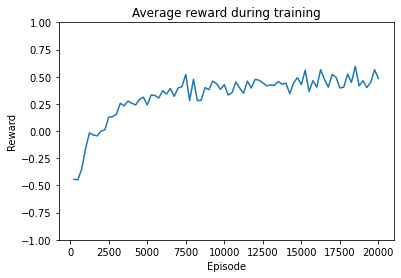


----- Trained  player-----
M_opt =  0.0
M_rand =  0.788

----- Optimal  player-----
M_opt =  0.0
M_rand =  0.92

----- Random  player-----
M_opt =  -0.932
M_rand =  0.0


In [10]:
# Plotting the average reward for every 250 games during training
running_average_rewards, x = running_average(stats['rewards'])
fig = plt.figure()
plt.plot(x, running_average_rewards)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()
if save_figs:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + '/rewards_Q1.png')
        fig.savefig(output_folder + '/rewards_Q1.eps', format = 'eps')

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)

names = ['Trained', 'Optimal', 'Random']
players = [QPlayer(Q=Q), OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)

#### 2.1.1 Decreasing exploration

In [ ]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
if not load:
    stats_dict_nstar = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar = pickle.load(handle)

plot_n_star = [1., 24460., 40000]
plot_stats(stats_dict_nstar, plot_n_star, 'n_star', "n^{\star}", save=True)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar, plot_n_star, 'n_star', "n^{\star}", save=True)
# plot_stats(stats_dict_nstar, vec_n_star, 'n_star', "n^{\star}", save=False)

#### 2.1.2 Good experts and bad experts

In [ ]:
n_star = 4000 # this should be picked from before not inserted manually
M = 11
vec_epsilon_opt = np.linspace(0,1,M)
print(vec_epsilon_opt)

In [ ]:
if not load:
    stats_dict_epsilon_opt = {}
    for epsilon_opt in vec_epsilon_opt:
        print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
        start = time.time()
        Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_epsilon_opt.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_opt = pickle.load(handle)

plot_epsilon_opt = [0., 0.5, 1.]
plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=True)
# plot_stats(stats_dict_epsilon_opt, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False)

### 2.2 Learning by self-practice

#### Question 7: Fixed $\epsilon$ first

In [ ]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [ ]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps_self = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        Q, stats = q_learning(env, num_episodes=num_episodes,
                            epsilon_exploration=epsilon, test_freq = 250, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps_self.update({epsilon: (stats, M_opt, M_rand)})

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self = pickle.load(handle)

epsilon_vec_plot = [0, 0.005, 0.1, 0.5]
plot_stats(stats_dict_eps_self, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs)
plot_stats(stats_dict_eps_self, epsilon_vec, "epsilon_self", "\epsilon", save=save_figs)

#### Question 8: Changing exploration rule, $\epsilon$ decay

In [ ]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
epsilon_min = 0.1
epsilon_max = 0.8

In [ ]:
if not load:
    stats_dict_nstar_self = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule,
                                test_freq=test_freq,  num_episodes=num_episodes, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=200)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=200)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar_self.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, "took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self = pickle.load(handle)

plot_n_star = [1., 4373., 24460., 40000]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star', "n^{\star}", save=save_figs)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star', "n^{\star}", save=save_figs)
plot_stats(stats_dict_nstar_self, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Question 9: TODO look for optimal $M_{opt}$ and $M_{rand}$

In [ ]:
### look for optimal values of M_opt and M_rand

#### Question 10: heat maps in 3 different states

In [ ]:
# Parametri ottimali di Q
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 4373
def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, verbose=True, self_practice=True)

In [ ]:
def heatmaps_subplots(grids, Q):
    fig, ax = plt.subplots(1, grids.shape[0], sharex='col', figsize=(15, 5))
    plt.subplots_adjust(wspace=1.5)
    grids_ = np.reshape(grids, (grids.shape[0], 3, 3))
    vmin = np.nanmin([Q[encode_state(grids[i, :])][:] for i in range(grids.shape[0])])
    vmax = np.nanmax([Q[encode_state(grids[i, :])][:] for i in range(grids.shape[0])])
    for i in range(grids.shape[0]):
        grid = grids[i, :]
        grid = np.reshape(grid, (3,3))
        df = Q[encode_state(grid)][:]
        df = np.reshape(df, (3, 3))
        ax[i].table(cellText=grids_[i])
        sns.heatmap(df, annot=True, mask=(grids_[i] != 0), linewidths=.5, vmin=vmin, vmax=vmax,
                    ax=ax[i], xticklabels=False, yticklabels=False, cmap="YlGnBu", 
                    cbar=False if i < (grids.shape[0]-1) else True, cbar_kws={"shrink": 1.2})
        ax[i].axis("off")

In [ ]:
grids = np.array([[1., 0., 0., -1., 1., 0., 0., -1., 0.], [-1., 0., 0., 1., 0., 0., 0., 1., -1.], [1., -1., 0., 0., 0., 0., 0., 0., 0.]])
heatmaps_subplots(grids, Q)

## Deep Q-Learning